<a href="https://colab.research.google.com/github/frogbysachs/LASA-Data-Science/blob/Unit-3/FrogSachU3Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ugly stuff

In [1]:
!pip install "preliz[full,notebook]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.4 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.9/509.9 kB 14.6 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: nbclient
    Found existing installation: nbclient 0.10.0
    Uninstalling nbclient-0.10.0:
      Successfully uninstalled nbclient-0.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency con

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm
import preliz as pz

#Guiding Question
The Collab is a North American convention for Jewish teens that I have helped to plan and run since 2022, and The Collab 2024 is coming up in late October.

I have information about how long registration was open for, as well as when each participant registered along that timeline.

My question, then, is: if I conjure an arbitrary additional participant that would be attending, when would they most likely have registered?



In 2024, registration for The Collab opened on May 30th and closed on September 23rd (total 116 days), with 194 registrants.

My first step is to create a spreadsheet with the date/time registration opened, the date/time of each instance of registration, and the elapsed time (measured in days) between those two dates/times.

In [3]:
#importing my spreadsheeet into Colab
url_reg = "https://raw.githubusercontent.com/frogbysachs/LASA-Data-Science/refs/heads/Unit-3/Data%20Science%20project%203-%20collab%20data%20-%20Sheet1.csv"
rawdata = pd.read_csv(url_reg)
rawdata

,Registration Opened,Created Date (GMT-05:00) Eastern [US & Canada],Elapsed time
0,5/30/24,8/30/24 21:29,92.895451
1,5/30/24,9/15/24 14:38,108.609815
2,5/30/24,9/8/24 16:27,101.685845
3,5/30/24,6/18/24 15:21,19.640197
4,5/30/24,8/26/24 17:31,88.729942
...,...,...,...
189,5/30/24,9/16/24 12:03,109.502315
190,5/30/24,8/26/24 17:31,88.729942
191,5/30/24,9/23/24 0:18,116.012928
192,5/30/24,7/29/24 15:49,60.659294


#Visualizing my data
First things first, I think a histogram is going to be super useful here to let me see what my data looks like on a discrete graph. I'll use 24 bins (1 for every 5 days or so).

After that, I want to see if I can use PreliZ to roughly model what my data would look like on a continuous graph. It seems like a Weibull distribution would be good for this because it has the right type of skew for what I'm working with here, but that doesn't necessarily mean that it'll be the right fit for my posterior down the line.

<Axes: title={'center': 'Elapsed time'}, ylabel='Frequency'>

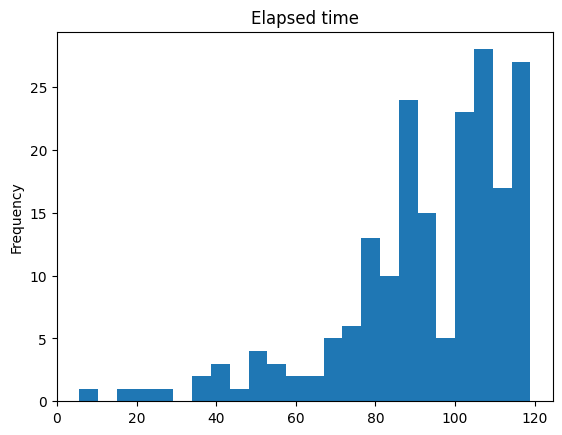

In [4]:
rawdata['Elapsed time'].plot(kind='hist', bins=24, title='Elapsed time')

/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/dufunc.py:287: RuntimeWarning: divide by zero encountered in nb_logpdf
  return super().__call__(*args, **kws)


<Axes: >

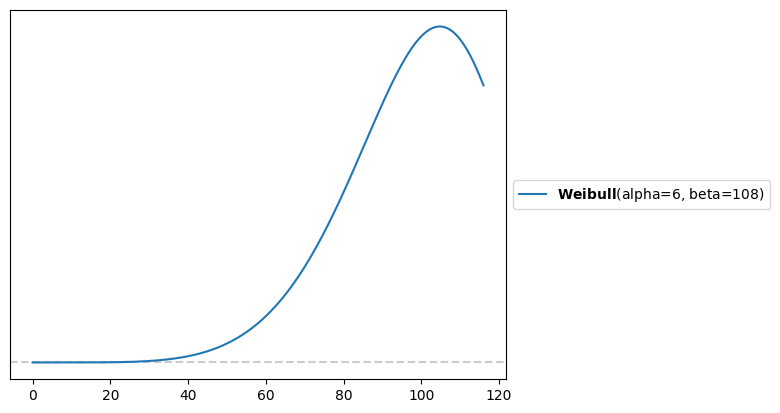

In [5]:
pz.Weibull(alpha=6,beta=108).plot_pdf(support=(0,116))

#Messing with posteriors
First we're going to try a Weibull distribution because the one I plotted above looked pretty good!

###Weibull

Output()

Output()

Output()

<Axes: xlabel='Weibull Distribution'>

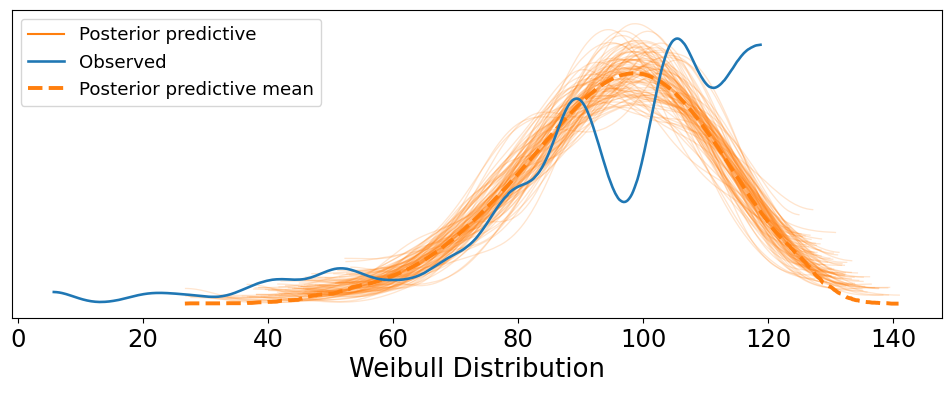

In [23]:
#Generating a posterior!
with pm.Model() as model_Weib:
  #I have no idea how wide or narrow the distribution around my peak will be
    Alpha = pm.Uniform('uniform', lower=7, upper=14)

    Beta = pm.Normal('beta', mu=110, sigma=10)

    take1 = pm.Weibull('Weibull Distribution', alpha=Alpha, beta=Beta, observed=rawdata["Elapsed time"])
    i_rawdata_Weib = pm.sample()

pm.sample_posterior_predictive(i_rawdata_Weib, model=model_Weib, extend_inferencedata=True)
az.plot_ppc(i_rawdata_Weib, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

So... that's pretty good, but I can't get it better no matter how much I adjust my mean, and the accuracy gets bad after 90 or so.

I'm thinking that Weibull may not have been the correct distribution for the job here. Next I'll try an exponential distribution because looking at the "Observed" graph, it seems like on average the slope is increasing the whole time.

###Exponential

In [24]:
with pm.Model() as model_Exp:
  #Lambda represents the mean of this distribution, so let's keep the same mean as last time
    Lambda = pm.Normal('lambda', mu=93, sigma=15)

    take2 = pm.Exponential('Exponential Distribution', lam=Lambda, observed=rawdata["Elapsed time"])
    i_rawdata_Exp = pm.sample()

Output()

Output()

Output()

<Axes: xlabel='take2'>

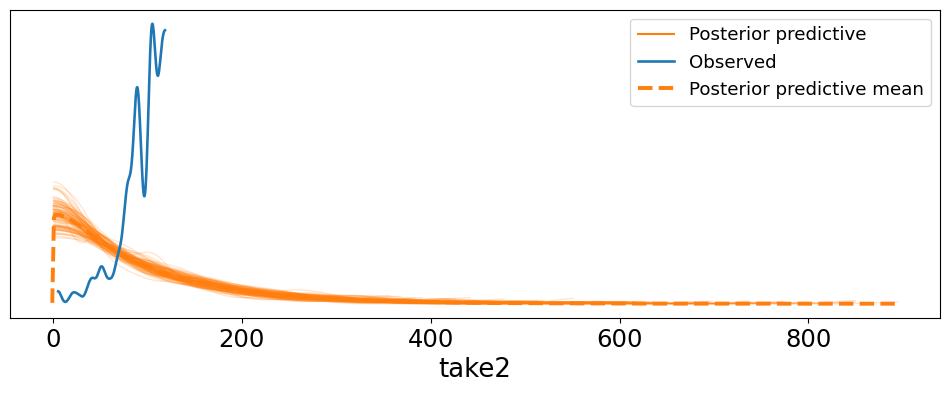

In [8]:
#We'll try the PPC again with my new exponential distribution:
pm.sample_posterior_predictive(i_rawdata_Exp, model=model_Exp, extend_inferencedata=True)
az.plot_ppc(i_rawdata_Exp, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

The problem here, I'm now realizing, is that the exponential function always has a negative slope rather than an always positive slope- so that didn't work **at all**. I'll try a Laplace distribution next and limit the support to just use the left side of it.

###Laplace

Output()

Output()

Output()

<Axes: xlabel='Laplace Distribution'>

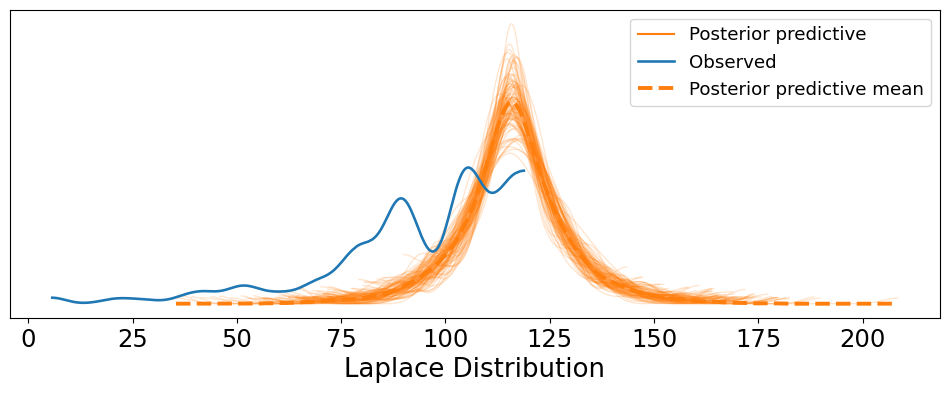

In [25]:
with pm.Model() as model_Laplace:
    Mu = 116
    #Guessing the scale parameter will be somewhere around 2, but I'm not totally sure
    B1 = pm.Normal('B1', mu=2, sigma=0.5)

    take3 = pm.Laplace('Laplace Distribution', mu = Mu, b = B1, observed=rawdata["Elapsed time"])
    i_rawdata_Laplace = pm.sample()

pm.sample_posterior_predictive(i_rawdata_Laplace, model=model_Laplace, extend_inferencedata=True)
az.plot_ppc(i_rawdata_Laplace, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

That's closer, but my model is predicting that people will continue registering after the deadline, which obviously isn't true (see: I wasn't sure how to limit the support).

There's a variation of Laplace called Asymmetric Laplace that will allow me to make my probability drop off after registration ends, so I'm going to try that next.

###Asymmetric Laplace

/usr/local/lib/python3.10/dist-packages/pytensor/tensor/math.py:893: FutureWarning: sgn is deprecated and will stop working in the future, use sign instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/math.py:893: FutureWarning: sgn is deprecated and will stop working in the future, use sign instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/math.py:893: FutureWarning: sgn is deprecated and will stop working in the future, use sign instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/math.py:893: FutureWarning: sgn is deprecated and will stop working in the future, use sign instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/math.py:893: FutureWarning: sgn is deprecated and will stop working in the future, use sign instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/math.py:893: FutureWarning: sgn is deprecated and will stop working in the

Output()

Output()

Output()

<Axes: xlabel='Asymmetric Laplace Distribution'>

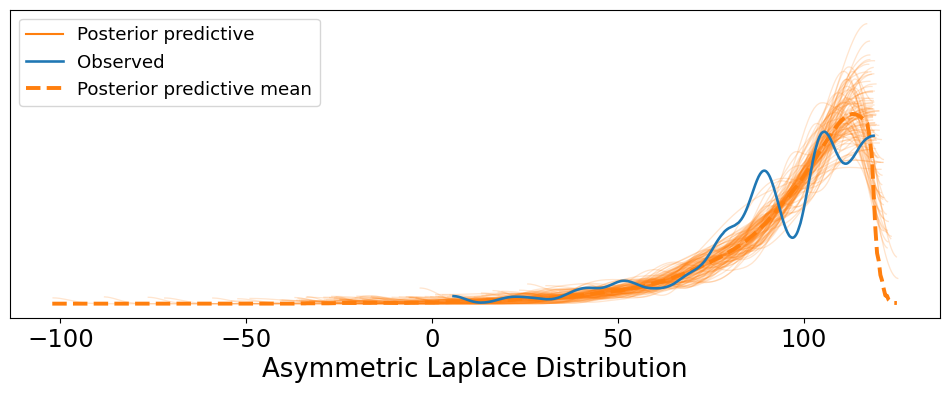

In [26]:
with pm.Model() as model_ALaplace:
    Mu = pm.Normal('Mu', mu=110, sigma=10)
    #Guessing the scale parameter will be somewhere around 2, but I'm not totally sure
    B2 = pm.Normal('B2', mu=1.4, sigma=0.1)
    Kappa = pm.Normal('Kappa', mu=3, sigma=0.5)

    take4 = pm.AsymmetricLaplace('Asymmetric Laplace Distribution', kappa = Kappa, mu = Mu, b = B2, observed=rawdata["Elapsed time"])
    i_rawdata_ALaplace = pm.sample()

pm.sample_posterior_predictive(i_rawdata_ALaplace, model=model_ALaplace, extend_inferencedata=True)
az.plot_ppc(i_rawdata_ALaplace, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

I kind of like this one! I did try one other distribution that didn't work- details below.

#One thing that didn't work
I tried a Truncated Normal distribution, but neither Mr. Arredondo nor I could get it to run, so I'm keeping it here but I don't actually care about it that much.

In [10]:
with pm.Model() as model_TNormal:
    Mu = pm.Normal('Mu', mu=80, sigma=1)

    Sig2 = pm.HalfNormal('Sig2', sigma=12)

    take4 = pm.TruncatedNormal('take4', mu = Mu, sigma = Sig2, lower = 0, upper = 116, observed=rawdata["Elapsed time"])
    i_rawdata_TNormal = pm.sample()

pm.sample_posterior_predictive(i_rawdata_TNormal, model=model_TNormal, extend_inferencedata=True)
az.plot_ppc(i_rawdata_TNormal, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'Mu': array(79.20775336), 'Sig2_log__': array(2.37714266)}

Logp initial evaluation results:
{'Mu': -1.23, 'Sig2': -0.74, 'take4': -inf}
You can call `model.debug()` for more details.

#Conclusions
Of all the distributions I tried, Weibull and Asymmetric Laplace worked the best- but they both have their strengths and drawbacks. The Weibull distribution is nice in that it only supports nonnegative real numbers, but it predicts people will continue to register after the deadline.

In comparison, the Asymmetric Laplace distribution has a nice sharp dropoff after the registration deadline, but it predicts that people can register on negative days (before registration opens).

I couldn't find a distribution that met both of my criteria, so my final conclusion is that **my Weibull and Asymmetric Laplace distributions are about equally good posteriors, but they should both be taken with a grain of salt.**

###Secret last thing
Last thing: to come back to my original question ("When would my imaginary extra participant have registered?), I can estimate the expected value for these two graphs:

1. For the Weibull distribution, I see a mean value of about 92 days.

2. For the Asymmetric Laplace distribution, it's a little harder, but I'm guesstimating about 96 days.